In [ ]:
'''
Steps to initialize project and install dependencies:

# sudo pip install pyyaml ipython jupyter ipyparallel pandas boto -U

# export PYSPARK_DRIVER_PYTHON=/usr/local/bin/jupyter
# export PYSPARK_DRIVER_PYTHON_OPTS="notebook --no-browser  --ip=0.0.0.0 --port=8888"
# source ~/.bashrc

# python -m pip install --user --upgrade pip
# pip3 install geopandas
# pip3 install descartes


'''




In [2]:
import re # using regular expression to find different seperators

In [3]:
# getting data from s3

device_status ='s3://dsci2020finalproject/devicestatus.txt'
lat_longs ='s3://dsci2020finalproject/lat_longs.txt'
sample_geo ='s3://dsci2020finalproject/sample_geo.txt'

In [4]:
# using regular expression to find the seperator
import re
device_status_log=sc.textFile(device_status)

temp_var = device_status_log.map(lambda k: re.split('[,|_/]', k))
temp_var.take(2)


[['2014-03-15:10:10:20',
  'Sorrento F41L',
  '8cc3b47e-bd01-4482-b500-28f2342679af',
  '7',
  '24',
  '39',
  'enabled',
  'disabled',
  'connected',
  '55',
  '67',
  '12',
  '33.6894754264',
  '-117.543308253'],
 ['2014-03-15:10:10:20',
  'MeeToo 1.0',
  'ef8c7564-0a1a-4650-a655-c8bbd5f8f943',
  '0',
  '31',
  '63',
  '70',
  '39',
  '27',
  'enabled',
  'enabled',
  'enabled',
  '37.4321088904',
  '-121.485029632']]

In [12]:
# Load data into dataframe

from pyspark.sql.types import *
from pyspark.sql.functions import * # importing col

log_df=temp_var.toDF()

device_status_df = log_df.select(col("_13").alias("latitude"), col("_14").alias("longitude"), col("_1").alias("date"), col("_2").alias("model"), col("_3").alias("device ID"))

# device_status_df = device_status_df.withColumn("date", unix_timestamp(device_status_df["date"], "yyyy-mm-dd:HH:mm:ss").cast('timestamp'))
device_status_df = device_status_df.withColumn("latitude", device_status_df["latitude"].cast('double'))
device_status_df = device_status_df.withColumn("longitude", device_status_df["longitude"].cast('double'))

device_status_df.show(3)


+-------------+--------------+-------------------+-------------+--------------------+
|     latitude|     longitude|               date|        model|           device ID|
+-------------+--------------+-------------------+-------------+--------------------+
|33.6894754264|-117.543308253|2014-03-15:10:10:20|Sorrento F41L|8cc3b47e-bd01-448...|
|37.4321088904|-121.485029632|2014-03-15:10:10:20|   MeeToo 1.0|ef8c7564-0a1a-465...|
|39.4378908349|-120.938978486|2014-03-15:10:10:20|   MeeToo 1.0|23eba027-b95a-472...|
+-------------+--------------+-------------------+-------------+--------------------+
only showing top 3 rows



In [13]:
# filter latitude and longitude with 0 values

device_status_df = device_status_df.filter("latitude != '0' or longitude != '0' ")

device_status_df.show()


+-------------+--------------+-------------------+--------------------+--------------------+
|     latitude|     longitude|               date|               model|           device ID|
+-------------+--------------+-------------------+--------------------+--------------------+
|33.6894754264|-117.543308253|2014-03-15:10:10:20|       Sorrento F41L|8cc3b47e-bd01-448...|
|37.4321088904|-121.485029632|2014-03-15:10:10:20|          MeeToo 1.0|ef8c7564-0a1a-465...|
|39.4378908349|-120.938978486|2014-03-15:10:10:20|          MeeToo 1.0|23eba027-b95a-472...|
|39.3635186767|-119.400334708|2014-03-15:10:10:20|       Sorrento F41L|707daba1-5640-4d6...|
|33.1913581092|-116.448242643|2014-03-15:10:10:20|Ronin Novelty Note 1|db66fe81-aa55-43b...|
|33.8343543748|-117.330000857|2014-03-15:10:10:20|       Sorrento F41L|ffa18088-69a0-433...|
|37.3803954321|-121.840756755|2014-03-15:10:10:20|       Sorrento F33L|66d678e6-9c87-48d...|
|34.1841062345|  -117.9435329|2014-03-15:10:10:20|          MeeToo 4.1

In [7]:
# need to re look

device_status_df = device_status_df.withColumn("manufacturer", split(col("model"), " ").getItem(0)).withColumn("model", split(col("model"), " ").getItem(1))


In [8]:
# device_status_df.write.option("header","true").text("s3a://dsci2020finalproject/updated_device_status")
 
    
device_status_df.coalesce(1).write.mode("overwrite").option("sep", ",").option("header","true").option("encoding", "UTF-8").csv("s3a://dsci2020finalproject/updated_device_status")

In [9]:
device_status_df.show()

# zip(device_status_df['longitude'], device_status_df['latitude'])

+-------------+--------------+-------------------+-------+--------------------+------------+
|     latitude|     longitude|               date|  model|           device ID|manufacturer|
+-------------+--------------+-------------------+-------+--------------------+------------+
|33.6894754264|-117.543308253|2014-03-15:10:10:20|   F41L|8cc3b47e-bd01-448...|    Sorrento|
|37.4321088904|-121.485029632|2014-03-15:10:10:20|    1.0|ef8c7564-0a1a-465...|      MeeToo|
|39.4378908349|-120.938978486|2014-03-15:10:10:20|    1.0|23eba027-b95a-472...|      MeeToo|
|39.3635186767|-119.400334708|2014-03-15:10:10:20|   F41L|707daba1-5640-4d6...|    Sorrento|
|33.1913581092|-116.448242643|2014-03-15:10:10:20|Novelty|db66fe81-aa55-43b...|       Ronin|
|33.8343543748|-117.330000857|2014-03-15:10:10:20|   F41L|ffa18088-69a0-433...|    Sorrento|
|37.3803954321|-121.840756755|2014-03-15:10:10:20|   F33L|66d678e6-9c87-48d...|    Sorrento|
|34.1841062345|  -117.9435329|2014-03-15:10:10:20|    4.1|673f7e4b-d52

In [10]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

pd_df = device_status_df.toPandas()

gdf = geopandas.GeoDataFrame(
    pd_df, geometry=geopandas.points_from_xy(pd_df.longitude, pd_df.latitude))

print(gdf.head())

        latitude       longitude                 date    model  \
0  33.6894754264  -117.543308253  2014-03-15:10:10:20     F41L   
1  37.4321088904  -121.485029632  2014-03-15:10:10:20      1.0   
2  39.4378908349  -120.938978486  2014-03-15:10:10:20      1.0   
3  39.3635186767  -119.400334708  2014-03-15:10:10:20     F41L   
4  33.1913581092  -116.448242643  2014-03-15:10:10:20  Novelty   

                              device ID manufacturer  \
0  8cc3b47e-bd01-4482-b500-28f2342679af     Sorrento   
1  ef8c7564-0a1a-4650-a655-c8bbd5f8f943       MeeToo   
2  23eba027-b95a-4729-9a4b-a3cca51c5548       MeeToo   
3  707daba1-5640-4d60-a6d9-1d6fa0645be0     Sorrento   
4  db66fe81-aa55-43b4-9418-fc6e7a00f891        Ronin   

                      geometry  
0  POINT (-117.54331 33.68948)  
1  POINT (-121.48503 37.43211)  
2  POINT (-120.93898 39.43789)  
3  POINT (-119.40033 39.36352)  
4  POINT (-116.44824 33.19136)  


        latitude       longitude                 date    model  \
0  33.6894754264  -117.543308253  2014-03-15:10:10:20     F41L   
1  37.4321088904  -121.485029632  2014-03-15:10:10:20      1.0   
2  39.4378908349  -120.938978486  2014-03-15:10:10:20      1.0   
3  39.3635186767  -119.400334708  2014-03-15:10:10:20     F41L   
4  33.1913581092  -116.448242643  2014-03-15:10:10:20  Novelty   

                              device ID manufacturer  \
0  8cc3b47e-bd01-4482-b500-28f2342679af     Sorrento   
1  ef8c7564-0a1a-4650-a655-c8bbd5f8f943       MeeToo   
2  23eba027-b95a-4729-9a4b-a3cca51c5548       MeeToo   
3  707daba1-5640-4d60-a6d9-1d6fa0645be0     Sorrento   
4  db66fe81-aa55-43b4-9418-fc6e7a00f891        Ronin   

                      geometry  
0  POINT (-117.54331 33.68948)  
1  POINT (-121.48503 37.43211)  
2  POINT (-120.93898 39.43789)  
3  POINT (-119.40033 39.36352)  
4  POINT (-116.44824 33.19136)  


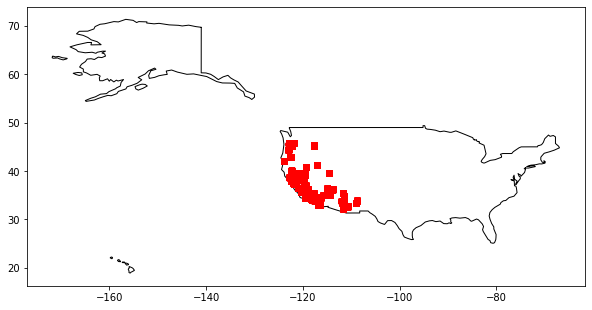

In [30]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# world.head()

# We restrict to South America.
ax = world[world.iso_a3 == 'USA'].plot(figsize=(10, 6),
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, marker='o', color='red', markersize=15)

plt.show()

In [2]:
# Step 2: Get and Visualize synthetic location data


In [34]:
# Loading sample geo data
sample_geo_log=sc.textFile(sample_geo)
header = sample_geo_log.first()

sample_geo_log = sample_geo_log.filter(lambda line: line != header)

# sample_geo_log =  sample_geo_log.filter(lambda line: line != [''])

temp_var1 = sample_geo_log.map(lambda k:k.split('\t'))
temp_var1 = temp_var1.filter(lambda line: line != [''])
temp_var1.take(3)

[['37.77253945', '-77.49954987', '1'],
 ['42.09013298', '-87.68915558', '2'],
 ['39.56341754', '-75.58753204', '3']]

In [35]:
log_df1=temp_var1.toDF(header.split("\t"))
log_df1.show()

+-----------+------------+----------+
|   Latitude|   Longitude|LocationID|
+-----------+------------+----------+
|37.77253945|-77.49954987|         1|
|42.09013298|-87.68915558|         2|
|39.56341754|-75.58753204|         3|
|39.45302347|-87.69374084|         4|
| 38.9537989|-77.01656342|         5|
|39.90031211|-75.74486542|         6|
|36.24009843|-115.1586914|         7|
|26.11330818|-80.09202576|         8|
|34.27036086|-118.3162918|         9|
|38.81664153|-97.62573242|        10|
|33.67614531|-118.1892776|        11|
|28.74612042|-81.44248199|        12|
|38.35152702|-81.69611359|        13|
|39.57271402|-86.35784912|        14|
|30.19543489|-81.45937347|        15|
|40.49826888|-74.16846466|        16|
|34.05601838|-117.9957428|        17|
|38.14426403|-122.5368347|        18|
|38.92940099|-94.39599609|        19|
|39.51639552|-77.81656647|        20|
+-----------+------------+----------+
only showing top 20 rows



In [37]:
df_sample_geo = log_df1.toPandas()

gdf = geopandas.GeoDataFrame(
    df_sample_geo, geometry=geopandas.points_from_xy(df_sample_geo.Longitude, df_sample_geo.Latitude))

print(gdf.head())

      Latitude     Longitude LocationID                    geometry
0  37.77253945  -77.49954987          1  POINT (-77.49955 37.77254)
1  42.09013298  -87.68915558          2  POINT (-87.68916 42.09013)
2  39.56341754  -75.58753204          3  POINT (-75.58753 39.56342)
3  39.45302347  -87.69374084          4  POINT (-87.69374 39.45302)
4   38.9537989  -77.01656342          5  POINT (-77.01656 38.95380)


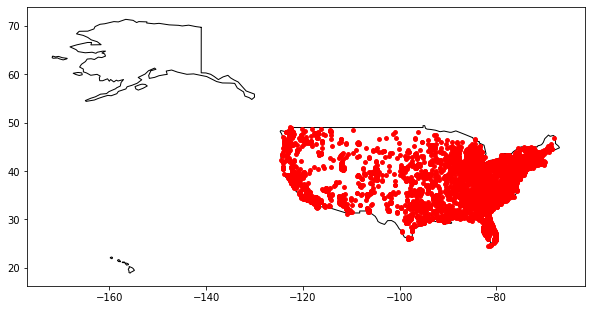

In [38]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# world.head()

# We restrict to South America.
ax = world[world.iso_a3 == 'USA'].plot(figsize=(10, 6),
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, marker='o', color='red', markersize=15)

plt.show()

In [39]:
# Loading lat_longs data
lat_longs_log=sc.textFile(lat_longs)

temp_var1 = lat_longs_log.map(lambda k:k.split())
temp_var1.take(3)

[['36.7', '3.216666666666667', '<http://dbpedia.org/resource/Algeria>'],
 ['42.5', '1.5166666666666666', '<http://dbpedia.org/resource/Andorra>'],
 ['12.516666666666667',
  '-70.03333333333333',
  '<http://dbpedia.org/resource/Aruba>']]

In [40]:
log_df2=temp_var1.toDF()
log_df2.show()

+------------------+------------------+--------------------+
|                _1|                _2|                  _3|
+------------------+------------------+--------------------+
|              36.7| 3.216666666666667|<http://dbpedia.o...|
|              42.5|1.5166666666666666|<http://dbpedia.o...|
|12.516666666666667|-70.03333333333333|<http://dbpedia.o...|
|-8.833333333333334|13.333333333333334|<http://dbpedia.o...|
|41.333333333333336|              19.8|<http://dbpedia.o...|
| 34.53333333333333| 69.13333333333334|<http://dbpedia.o...|
|40.416666666666664|49.833333333333336|<http://dbpedia.o...|
| 39.93333333333333| 32.86666666666667|<http://dbpedia.o...|
| 52.36666666666667|               4.9|<http://dbpedia.o...|
|             50.46|              2.13|<http://dbpedia.o...|
|17.116666666666667|            -61.85|<http://dbpedia.o...|
| 57.04638888888889| 9.919166666666667|<http://dbpedia.o...|
|             56.15|10.216666666666667|<http://dbpedia.o...|
|            34.929|    

In [42]:
df_lat_longs = log_df2.toPandas()

gdf = geopandas.GeoDataFrame(
    df_lat_longs, geometry=geopandas.points_from_xy(df_lat_longs._1, df_lat_longs._2))

print(gdf.head())

                   _1                  _2  \
0                36.7   3.216666666666667   
1                42.5  1.5166666666666666   
2  12.516666666666667  -70.03333333333333   
3  -8.833333333333334  13.333333333333334   
4  41.333333333333336                19.8   

                                      _3                    geometry  
0  <http://dbpedia.org/resource/Algeria>    POINT (36.70000 3.21667)  
1  <http://dbpedia.org/resource/Andorra>    POINT (42.50000 1.51667)  
2    <http://dbpedia.org/resource/Aruba>  POINT (12.51667 -70.03333)  
3   <http://dbpedia.org/resource/Angola>   POINT (-8.83333 13.33333)  
4  <http://dbpedia.org/resource/Albania>   POINT (41.33333 19.80000)  


In [1]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# world.head()

# We restrict to South America.
ax = world.plot(figsize=(20, 12), edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, marker='o', color='red', markersize=15)

plt.show()

NameError: name 'geopandas' is not defined